# Predict Housing Prices using Advanced Regression Techniques
#### A [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) Competition
### Surya Keswani | sukeswan@ucsc.edu | June 1 2020

This notebook predicts housing prices using advanced regression techniques. This data is from the Kaggle competition linked above. The data for this notebook can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The data includes a description, training data, testing data, and a sample submission file. 

To run this notebook click *Kernel -> Restart and Run All*. Keep in mind some of the functions take a few minutes to finalize the outputs. If you are running each block at a time and encounter a KeyError, click *Kernel -> Restart and Run All*, and that should fix it. The notebook will be done running when you see NOTEBOOK COMPLETED at the bottom of the output. To run this script, all the corresponding libraries below must be installed and properly running. I recommend creating a virtual environment using Anaconda. You will know all libraries have successfully imported if you see "Imports completed" after the next cell.

In [1]:
import pandas as pd                                                             
import seaborn as sns
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import sys

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

print("Imports completed")

Imports completed


/opt/anaconda3/envs/Clustering/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Reading the Data
The first step is to read the train and test data into a pandas dataframe. This cell prints out some information about the dataset. 

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

frames = [train_data, test_data]
all_data = pd.concat(frames)
testID = test_data["Id"]

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:", test_data.shape)
print("Shape of All Data:", all_data.shape)

print("\nThe features of the dataset:", all_data.columns)

all_data.head(5)

Shape of Training Data: (1460, 81)
Shape of Test Data: (1459, 80)
Shape of All Data: (2919, 81)

The features of the dataset: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


#### First Look at the Dataset
Before feature engineering and processing the data, looking at the entire dataset gives a better understanding of which attributes are important and which can be excluded. This cell will display some numerical information about the label (Sales Price) and also show that the label is positively skewed. Below that will be a heatmap showing which attributes are most correlated with the label.

Overlook of Sales Prices of dataset:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


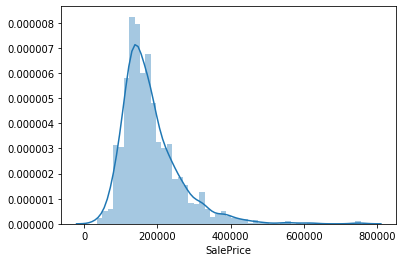

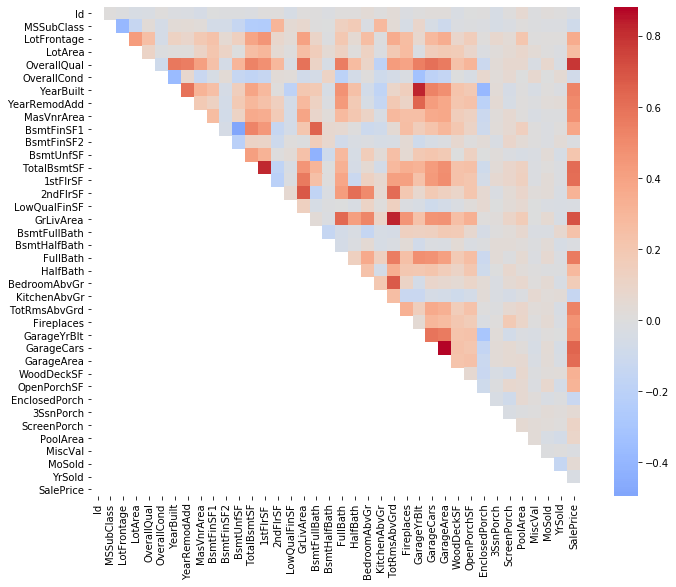

In [3]:
print("Overlook of Sales Prices of dataset:")
print(train_data['SalePrice'].describe())

# histogram
sns.distplot(train_data['SalePrice']);

corrmat = train_data.corr()
fig, ax = plt.subplots(figsize=(12,9))
mask = np.tril(corrmat)
sns.heatmap(corrmat,center = 0, square=True, cmap = 'coolwarm', mask = mask)


#### Narrowing Down the Attributes

The smaller heatmap below shows the 10 most correlated varaibles with sales price. Some of the varaibles are very similar, such as `GarageCars` and `GarageArea` so only one of those is needed. Picking `GarageCars` is a better option because it is more correlated with `SalesPrice`. `GrLivArea` and `TotRmsAbvGrd` are very similar so `TotRmsAbvGrd` can also be dropped. The same thing with `1stFlrSF`(dropped) and `TotalBsmtSF`(kept). 

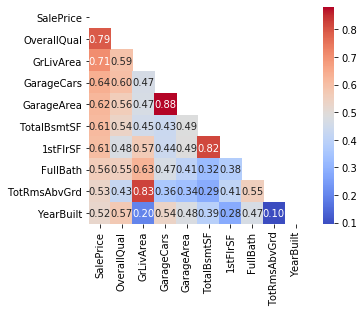

In [4]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
mask = np.triu(cm)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap = 'coolwarm', mask = mask)
plt.show()

del all_data['GarageCars']
del all_data['TotRmsAbvGrd']
del all_data['1stFlrSF']

#### Understanding the Key Attributes
Now that some key attributes have been isolated, some more information about each attribute would be helpful. This cell displays a graph of each of these key attributes plotted against one another. Some interesting patterns  to spot are the 2 outliers in the bottom left corner of the `GrLivArea` and `SalesPrice` chart. Some attributes such as `GrLivArea` and `TotalBsmtSF` have a linear relationship with `SalesPrice`. Other attributes such as `OverallQual` have exponential relationships with the label. Note: This visualization takes 30 seconds to render. 

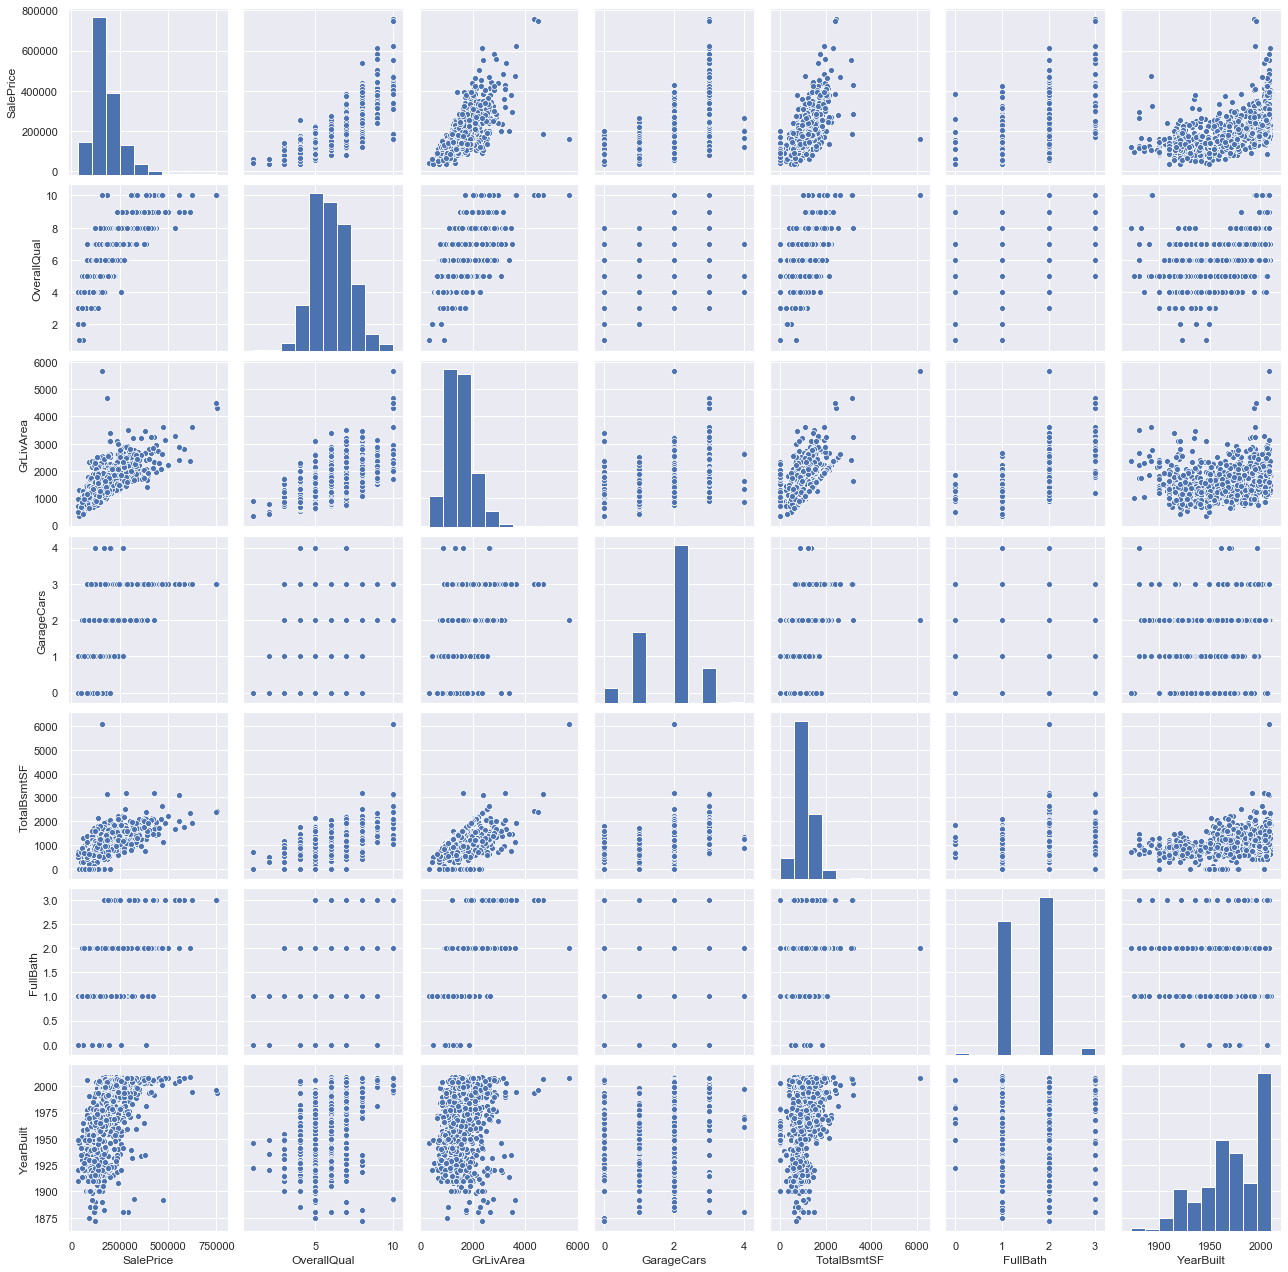

In [5]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols], height = 2.5)
plt.show();

#### Missing Training Data Overview
The dataset being used contains some missing data. Below is a table of the attributes with the highest amounts of missing training data. 

In [6]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Table indicating Missing Training Data:")
missing_data.head(20)

Table indicating Missing Training Data:


,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


#### Drop and Replace Missing Training Data

Anything with more than 20% missing data is disregarded (`PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu`). None of these features are highly correlated with the sales price of a home and intuitively it makes sense that misc. features and alley access do not play a large role in determining the price of a home. 

The `LotFrontage` variable can be an important variable in assessing the price of a house. For this reason, the variable is kept and the missing values are replaced with the median value of the neighborhood lot frontage. Houses in the same neighborhoods will have similar front yard. 

All of the Garage variables are missing the same amount of data and are most likely referring to the same observations. `GarageCars` is the only garage variable kept because it is most correlated with the label. 

For the same reasons as the garage variables, only the most correlated basement variable (`TotalBsmtSF`) is kept. 

`MasVnrArea` and `MasVnrType` also are relatively trivial attributes when calculating the price of a house. Furthermore, the variables are highly correlated with `YearBuilt` and `OverallQual` respectively, so the 2 veneer variables can be disregarded. 

The one instance missing `Electrical` information is substituted with the most common form of the electrical system from the data.

In [7]:
del all_data['PoolQC']
del all_data['MiscFeature']
del all_data['Alley']
del all_data['Fence']
del all_data['FireplaceQu']

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

del all_data['GarageCond']
del all_data['GarageType']
del all_data['GarageYrBlt']
del all_data['GarageFinish']
del all_data['GarageQual']

del all_data['BsmtExposure']
del all_data['BsmtFinType2']
del all_data['BsmtFinType1']
del all_data['BsmtCond']
del all_data['BsmtQual']

del all_data['MasVnrArea']
del all_data['MasVnrType']

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

train_update = all_data.head(1459)
print("The amount of missing data from the training data is now:",train_update.isnull().sum().max())

The amount of missing data from the training data is now: 0


#### Missing Test Data Overview
The dataset being used constains some missing data. Below is a table of the attributes with the highest amounts of missing test data.

In [8]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print("Table indicating Missing Test Data:")
missing_data.head(16)

Table indicating Missing Test Data:


,Total,Percent
SalePrice,1459,49.982871
MSZoning,4,0.137033
Utilities,2,0.068517
BsmtFullBath,2,0.068517
BsmtHalfBath,2,0.068517
Functional,2,0.068517
GarageArea,1,0.034258
Exterior1st,1,0.034258
Exterior2nd,1,0.034258
BsmtFinSF1,1,0.034258


#### Drop and Replace Missing Testing Data

The data table above shows the test set has some missing data. The `SalePrice` of every test data point is missing because `SalesPrice` is the label that must be predicted.

The data points missing the `MSZoning` attribute are filled with the most common zoning code of the dataset (RL aka residential low density).

Because every single datapoint in the train and test set has public utilities (minus the two missing values and one no sewage value), this attribute will not contribute to any predictive model so `Utilities` is dropped from the dataset. 

All of the missing values for the basement attributes are marked as zero because basements most likely do not exist for those instances of houses. This reasoning also applies to the one missing data point for `GarageArea`. 

The missing `Functional` values are filled with assumed type typical, as per the instructions of the dataset. 

The remaining missing values for `Exterior1st`, `Exterior2nd`, `KitchenQual`, `SaleType`, are filled with the most common value for the respective categories.

In [9]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

del all_data['Utilities']

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea'):
    all_data[col] = all_data[col].fillna(0)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

print("The amount of missing data from the test data is now:",all_data.isnull().sum().max() - 1459)

train_data = all_data.head(1460)
test_data = all_data.tail(1459)
print("Shape of training data after being processed: ", train_data.shape)
print("Shape of test data after being processed: ", test_data.shape)

The amount of missing data from the test data is now: 0
Shape of training data after being processed:  (1460, 60)
Shape of test data after being processed:  (1459, 60)


#### Standardize the Skew: SalePrice
As shown below, much of the data is positively skewed. To account for the skew, the data distributions have been adjusted to fit a normal distribution. To fix this positive skew, a log transformation has been applied to the SalePrice. 

Original distribution of SalePrice data


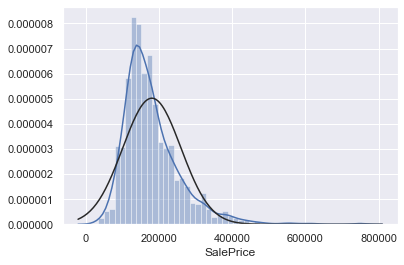

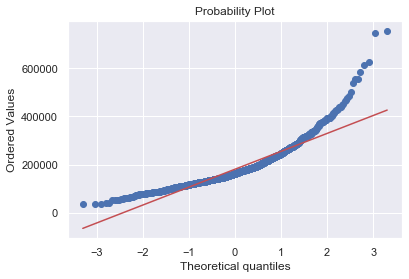

In [10]:
print("Original distribution of SalePrice data")
sns.distplot(train_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

Distribution of Log Transformed Data of SalePrice data


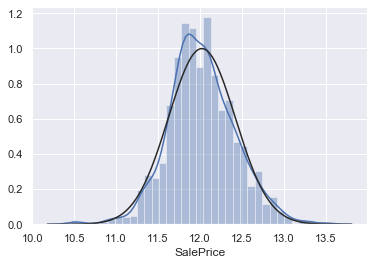

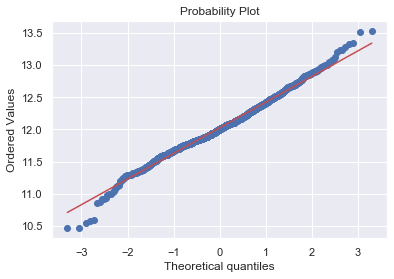

In [11]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])

print("Distribution of Log Transformed Data of SalePrice data")
sns.distplot(train_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

#### Standardize the Skew: Attributes

Now that the label has been normalized, the same can be done to the numerical attributes. Below is a list of all the skewed variables. They are adjusted using a log transformation. The cell below also converts the categorical data into dummy variables. After being normalized, `LowQualFinSF`, `3SsnPorch`, `PoolArea`, `MiscVal` all have skew values of NaN so those attributes are dropped. 

In [12]:
numeric_feats = train_data.dtypes[train_data.dtypes != "object"].index

skewed_feats = train_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(80))


for feat in numeric_feats:
    value = skewness.loc[feat,'Skew']
    if((value > 5) or (value < 0) and (feat !='id')):
        train_data[feat] = np.log(train_data[feat])
        
all_data = pd.get_dummies(all_data)

train_labels = train_data['SalePrice'].values
del all_data["SalePrice"]
del all_data["LowQualFinSF"]
del all_data["3SsnPorch"]
del all_data["PoolArea"]
del all_data["MiscVal"]

train_data = all_data.head(1460)
test_data = all_data.tail(1459)
print("\n\nShape of training data after being processed: ", train_data.shape)
print("Shape of test data after being processed: ", test_data.shape)


Skew in numerical features: 

                    Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
EnclosedPorch   3.086696
OpenPorchSF     2.361912
LotFrontage     2.211281
BsmtFinSF1      1.683771
WoodDeckSF      1.539792
TotalBsmtSF     1.522688
MSSubClass      1.406210
GrLivArea       1.365156
BsmtUnfSF       0.919323
2ndFlrSF        0.812194
OverallCond     0.692355
HalfBath        0.675203
Fireplaces      0.648898
BsmtFullBath    0.595454
OverallQual     0.216721
MoSold          0.211835
BedroomAbvGr    0.211572
GarageArea      0.179796
SalePrice       0.121210
YrSold          0.096170
FullBath        0.036524
Id              0.000000
YearRemodAdd   -0.503044
YearBuilt      -0.612831


Shape of training data after being processed:  (1460, 213)
Shape of test data after being processed:  (1459, 213)


#### Modeling the Data

Now that the data has been processed, it can be used to build and test some regression models. The cell below uses 5-way cross-validation to score the accuracy of the training data. The metric calculated with each model is the Root Mean Squared Error, where the value between the logarithm of the predicted value and the logarithm of the observed sales price. Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. In addition, the explained variance score is calculated for each model. 

In [13]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data.values)
    rmse= np.sqrt(-cross_val_score(model, train_data.values, train_labels, scoring="neg_mean_squared_error", cv = kf))
    ev = cross_val_score(model, train_data.values, train_labels, scoring="explained_variance", cv = kf)
    return(rmse,ev)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score1, score2 = rmsle_cv(lasso)
print("\nLasso RMSE score: {:.4f}, STD({:.4f})".format(score1.mean(), score1.std()))
print("Lasso EV score: {:.4f}, STD({:.4f})\n".format(score2.mean(), score2.std()))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score1, score2 = rmsle_cv(ENet)
print("ElasticNet RSME score: {:.4f}, STD({:.4f})".format(score1.mean(), score1.std()))
print("ElasticNet EV score: {:.4f}, STD({:.4f})\n".format(score2.mean(), score2.std()))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score1, score2 = rmsle_cv(KRR)
print("Kernel Ridge RMSE score: {:.4f}, STD({:.4f})".format(score1.mean(), score1.std()))
print("Kernel Ridge EV score: {:.4f}, STD({:.4f})\n".format(score2.mean(), score2.std()))

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score1, score2 = rmsle_cv(GBoost)
print("Gradient Boosting RSME score: {:.4f}, STD({:.4f})".format(score1.mean(), score1.std()))
print("Gradient Boosting EV score: {:.4f}, STD({:.4f})\n".format(score2.mean(), score2.std()))

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score1, score2 = rmsle_cv(model_xgb)
print("Xgboost RSME score: {:.4f}, STD({:.4f})".format(score1.mean(), score1.std()))
print("Xgboost EV score: {:.4f}, STD({:.4f})\n".format(score2.mean(), score2.std()))

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score1, score2 = rmsle_cv(model_lgb)
print("LGBM RSME score: {:.4f}, STD({:.4f})" .format(score1.mean(), score1.std()))
print("LGBM EV score: {:.4f}, STD({:.4f})\n" .format(score2.mean(), score2.std()))



Lasso RMSE score: 0.1375, STD(0.0348)
Lasso EV score: 0.8748, STD(0.0673)

ElasticNet RSME score: 0.1375, STD(0.0345)
ElasticNet EV score: 0.8749, STD(0.0669)

Kernel Ridge RMSE score: 0.4071, STD(0.0447)
Kernel Ridge EV score: -0.0296, STD(0.1615)

Gradient Boosting RSME score: 0.1252, STD(0.0132)
Gradient Boosting EV score: 0.9018, STD(0.0143)

Xgboost RSME score: 0.1237, STD(0.0111)
Xgboost EV score: 0.9045, STD(0.0131)

LGBM RSME score: 0.1244, STD(0.0117)
LGBM EV score: 0.9029, STD(0.0134)



#### Final Submission 

Because XGBoost has the best results, it is the model that is used to predict the test data. The test data result has an RSME Score of 0.14412. The predictions for the competition can be found in the submissions.csv file. 

In [14]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_data, train_labels)
y_pred1 = xgb_model.predict(test_data)

y_pred = []
for value in y_pred1:
    y_pred.append(np.exp(value))


sub = pd.DataFrame()
sub['Id'] = testID
sub['SalePrice'] = y_pred
sub.to_csv('submission.csv',index=False)

print("NOTEBOOK COMPLETED")

[12:02:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
NOTEBOOK COMPLETED


#### Sources


1. Stacked Regressions to predict House Prices - [Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
2. Regularized Linear Models - [Alexandru Papiu](https://www.kaggle.com/apapiu/regularized-linear-models)
3. A study on Regression applied to the Ames dataset - [juliencs](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
4. Comprehensive Data Exploration with Python - [Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)